In [ ]:
import os 
root = os.path.abspath('')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.io as sio

# 'noise_study_ood'
# noise_study_ood_phy_domain_sampled
studies = ['noise_study_ood_domain_quad']
sigmas = [0.0, .2, .5] #, 0.01, 0.1, 0.2, 0.5

for study in studies:
    for sigma in sigmas:
        d = f'{root}/results/{study}/{sigma}'
        print(d)
        mat = sio.loadmat(f'{d}/SeismicWave_TDSF_forward_PGNN_v1_result.mat')
        Ymax, Ymin, Xmax, Xmin = mat['Ymax'], mat['Ymin'], mat['Xmax'], mat['Xmin']
        
        Yhat_test, Ytest, Xtest  = mat['Yhat_test'], mat['Ytest'], mat['Xtest']
        Yhat_train, Ytrain, Xtrain = mat['Yhat_train'], mat['Ytrain'], mat['Xtrain']
        Yhat_val, Yval, Xval = mat['Yhat_val'], mat['Yval'], mat['Xval']
        
        print(Yhat_test.shape, Ytest.shape, Xtest.shape)
        print(Yhat_train.shape, Ytrain.shape, Xtrain.shape)
        print(Yhat_val.shape, Yval.shape, Xval.shape)
        
        Ymax, Ymin, Xmax, Xmin = Ymax[0,0], Ymin[0,0], Xmax[0,0], Xmin[0,0]
        
        # make a seaborn scatterplot with a continuous color mapping
        ax = sns.scatterplot(x=Ytest[:,0], y=Yhat_test[:,0], hue=Xtest[:,0], palette='viridis', alpha=0.5)
        plt.plot([Ymin, Ymax], [Ymin, Ymax], color='black', lw=1, linestyle='--')
        plt.xlabel('True')
        plt.ylabel('Predicted')
        plt.title(f'Noise: {sigma}')
        plt.savefig(f'{root}/results/{study}/{sigma}/disp_true_v_pred_test_yield.png')
        plt.show()

        ax = sns.scatterplot(x=Ytest[:,0], y=Yhat_test[:,0], hue=Xtest[:,1], palette='viridis', alpha=0.5)
        plt.plot([Ymin, Ymax], [Ymin, Ymax], color='black', lw=1, linestyle='--')
        plt.xlabel('True')
        plt.ylabel('Predicted')
        plt.title(f'Noise: {sigma}')
        plt.savefig(f'{root}/results/{study}/{sigma}/disp_true_v_pred_test_depth.png')
        plt.show()

        residuals = (Yhat_test - Ytest)**2
        ax = sns.scatterplot(x=Ytest[:,0], y=residuals[:,0], hue=Xtest[:,0], palette='viridis', alpha=0.5)
        plt.xlabel('True')
        plt.ylabel('Residual')
        plt.title(f'Noise: {sigma}')
        plt.savefig(f'{root}/results/{study}/{sigma}/disp_resid_test_yield.png')
        plt.show()

        ax = sns.scatterplot(x=Ytest[:,0], y=residuals[:,0], hue=Xtest[:,1], palette='viridis', alpha=0.5)
        plt.xlabel('True')
        plt.ylabel('Residual')
        plt.title(f'Noise: {sigma}')
        plt.savefig(f'{root}/results/{study}/{sigma}/disp_resid_test_depth.png')
        plt.show()

        n_t = 100
        n_test = int(Ytest.shape[0]//n_t)
        t = Xtest[:,-1].reshape(n_test, n_t)
        residuals = Ytest.reshape(n_test, n_t) - Yhat_test.reshape(n_test, n_t)

        ax = sns.lineplot(x=t.reshape(-1,1)[:,0], y=residuals.reshape(-1,1)[:,0], alpha=0.5, errorbar='sd')
        plt.xlabel('Time')
        plt.ylabel('Residual')
        plt.title(f'Noise: {sigma}')
        plt.savefig(f'{root}/results/{study}/{sigma}/disp_resid_v_time_errbar.png')
        plt.show()

        n_t = 100
        Xplot = np.vstack([Xtrain, Xval, Xtest])
        Yplot = np.vstack([Ytrain, Yval, Ytest])
        Yhat_plot = np.vstack([Yhat_train, Yhat_val, Yhat_test])
        n = int(Xplot.shape[0]//n_t)
        w = np.unique(Xplot[:,0].reshape(n, n_t), axis=1)
        h = np.unique(Xplot[:,1].reshape(n, n_t), axis=1)
        residuals = (abs(Yhat_plot.reshape(n, n_t) - Yplot.reshape(n, n_t))).mean(axis=1)
        plt.scatter(w, h, c=residuals, cmap='viridis', alpha=0.5)
        plt.colorbar()
        plt.xlabel('Yield')
        plt.ylabel('Depth')
        plt.title(f'Mean Absolute Residual | Noise: {sigma}')
        plt.savefig(f'{root}/results/{study}/{sigma}/disp_resid_v_yield_depth.png')
        plt.show()

        
        



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
path = f'{root}/data'

filename = 'tdsf_002_train.pickle'
df_train_all = pd.read_pickle(path + '/' + filename)

filename = 'tdsf_002_val.pickle'
df_test_all = pd.read_pickle(path + '/' + filename)

df_data_all = pd.concat([df_train_all, df_test_all], axis=0)


#%% Select Material

# [Tuff-Rhyolite, Granite, Shale, Salt, Wet-Granite, Wet-Tuff]

name_prefix = '_FAR.'
name_material = 'Tuff-Rhyolite'

df_data = df_data_all[df_data_all['material'] == name_prefix + name_material]
df_data = df_data.reset_index(drop=True)

# round YIELD and DEPTH to 2 decimal places
df_data.YIELD = df_data.YIELD.round(2)
df_data.DEPTH = df_data.DEPTH.round(2)

# splits df into train and test by yield and depth quantiles
# qnts = [.7, .3] # inner-outer domain split
qnts = [.4] # quad domain split
ylds, dpths = df_data.YIELD.quantile(qnts, interpolation='nearest'), df_data.DEPTH.quantile(qnts, interpolation='nearest')

# # inner-outer domain split mask
# train_qnt = (df_data.YIELD >= ylds.min()) & (df_data.YIELD <= ylds.max()) & (df_data.DEPTH >= dpths.min()) & (df_data.DEPTH <= dpths.max())

# quad domain split mask
train_qnt = (df_data.YIELD <= ylds.max()) & (df_data.DEPTH <= dpths.max())

# split data into train and test by domain (inner and outer)
df_train = df_data[train_qnt].reset_index(drop=True)
df_test = df_data[~train_qnt].reset_index(drop=True)

# split train into train and validation, randomly selected from the inner domain
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=0)
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)


# plot train and test yields and depths
s = 30
plt.figure()
plt.scatter(df_train.YIELD, df_train.DEPTH, label='Training Set', color='red', alpha=0.2, s=s)
plt.scatter(df_val.YIELD, df_val.DEPTH, label='Validation Set', color='black', alpha=0.2, s=s)
plt.scatter(df_test.YIELD, df_test.DEPTH, label='Test Set', color='blue', alpha=0.2, s=s)
plt.legend()

In [ ]:
import os 
root = os.path.abspath('')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.io as sio

from matplotlib.colors import Colormap
from matplotlib import cm




# noise_study_ood_phy_domain_sampled, norm = plt.Normalize(0.00010848209, 0.002615124)
# noise_study_ood_domain_no_phy, norm = plt.Normalize(0.0001390961, 0.0025011438) 
# superset, norm = plt.Normalize(0.00010848209, 0.002615124) 


studies = ['noise_study_ood_domain_quad_corr']
sigmas = [0. , .2, .5]
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4), layout='compressed')
axs = axs.ravel()
ax = axs[0]
s = 24
ax.scatter(df_train.YIELD, df_train.DEPTH, label='Train', color='red', alpha=1, s=s)
ax.scatter(df_val.YIELD, df_val.DEPTH, label='Val', color='black', alpha=1, s=s)
ax.scatter(df_test.YIELD, df_test.DEPTH, label='Test', color='blue', alpha=1, s=s)
ax.set_ylabel('Depth', fontsize=16)
ax.set_xlabel('Yield', fontsize=16)
ax.legend(ncol=3, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, borderaxespad=0)
# ax.set_title(f'Splits')


nmin, nmax = 0.,0.
norm = plt.Normalize(0., 0.005) 
cmap = cm.get_cmap('viridis')
im = cm.ScalarMappable(norm=norm, cmap=cmap)

i = 1
nmax = -np.inf
nmin = np.inf
for study in studies:
    for sigma in sigmas:
        ax = axs[i]
                
        d = f'{root}/results/{study}/{sigma}'
        print(d)
        mat = sio.loadmat(f'{d}/SeismicWave_TDSF_forward_PGNN_v1_result.mat')
        Ymax, Ymin, Xmax, Xmin = mat['Ymax'], mat['Ymin'], mat['Xmax'], mat['Xmin']
        
        Yhat_test, Ytest, Xtest  = mat['Yhat_test'], mat['Ytest'], mat['Xtest']
        Yhat_train, Ytrain, Xtrain = mat['Yhat_train'], mat['Ytrain'], mat['Xtrain']
        Yhat_val, Yval, Xval = mat['Yhat_val'], mat['Yval'], mat['Xval']
        
        print(Yhat_test.shape, Ytest.shape, Xtest.shape)
        print(Yhat_train.shape, Ytrain.shape, Xtrain.shape)
        print(Yhat_val.shape, Yval.shape, Xval.shape)
        
        Ymax, Ymin, Xmax, Xmin = Ymax[0,0], Ymin[0,0], Xmax[0,0], Xmin[0,0]
        
        n_t = 100
        Xplot = np.vstack([Xtrain, Xval, Xtest])
        Yplot = np.vstack([Ytrain, Yval, Ytest])
        Yhat_plot = np.vstack([Yhat_train, Yhat_val, Yhat_test])
        n = int(Xplot.shape[0]//n_t)
        w = np.unique(Xplot[:,0].reshape(n, n_t), axis=1)
        h = np.unique(Xplot[:,1].reshape(n, n_t), axis=1)
        residuals = ((abs(Yhat_plot.reshape(n, n_t) - Yplot.reshape(n, n_t)))).mean(axis=1)
        
        if residuals.max() > nmax:
            nmax = residuals.max()
        if residuals.min() < nmin:
            nmin = residuals.min()
            
        ax.scatter(w, h, c=residuals, cmap=cmap, s = 50, alpha=0.5)
        # ax.set_cmap(norm)
        ax.set_title(f'Noise: {sigma}')

        i+=1

norm = plt.Normalize(nmin, nmax) 
im = cm.ScalarMappable(norm=norm, cmap=cmap)
for i,ax in enumerate(fig.axes):
    if i==0:
        continue
    sc = ax.get_children()[0]
    sc.set_norm(norm)
    sc.set_cmap(cmap)
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01)
# fig.tight_layout()
cbar.set_label('Mean Absolute Residual', fontsize=12, rotation=270, labelpad=20)
plt.savefig(f'{root}/results/{study}/disp_resid_v_yield_depth.png')
plt.show()
        



# OOD Quad Corr 

/tmp/ipykernel_2718/2273326706.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


/home/mitch/PythonProjects/tdsf/results/noise_study_ood_domain_quad_corr/0.0_1_1_0
(797000, 1) (797000, 1) (797000, 3)
(129200, 1) (129200, 1) (129200, 3)
(32400, 1) (32400, 1) (32400, 3)
/home/mitch/PythonProjects/tdsf/results/noise_study_ood_domain_quad_corr/0.2_1_1_0
(797000, 1) (797000, 1) (797000, 3)
(129200, 1) (129200, 1) (129200, 3)
(32400, 1) (32400, 1) (32400, 3)
/home/mitch/PythonProjects/tdsf/results/noise_study_ood_domain_quad_corr/0.5_1_1_0
(797000, 1) (797000, 1) (797000, 3)
(129200, 1) (129200, 1) (129200, 3)
(32400, 1) (32400, 1) (32400, 3)
/home/mitch/PythonProjects/tdsf/results/noise_study_ood_domain_quad_corr/0.0_1_1_1
(797000, 1) (797000, 1) (797000, 3)
(129200, 1) (129200, 1) (129200, 3)
(32400, 1) (32400, 1) (32400, 3)
/home/mitch/PythonProjects/tdsf/results/noise_study_ood_domain_quad_corr/0.2_1_1_1
(797000, 1) (797000, 1) (797000, 3)
(129200, 1) (129200, 1) (129200, 3)
(32400, 1) (32400, 1) (32400, 3)
/home/mitch/PythonProjects/tdsf/results/noise_study_ood_doma

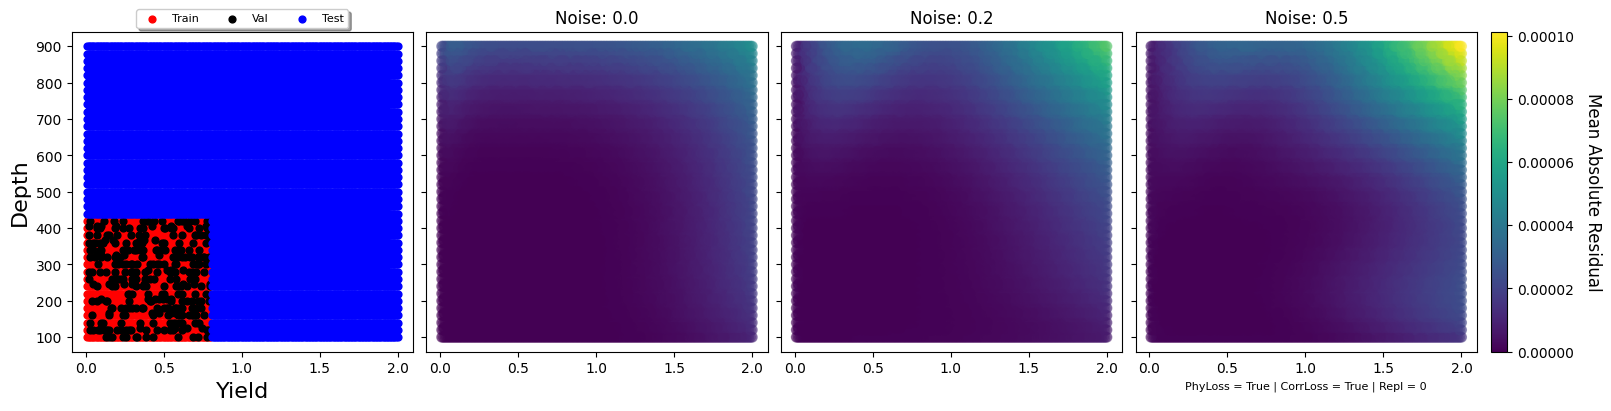

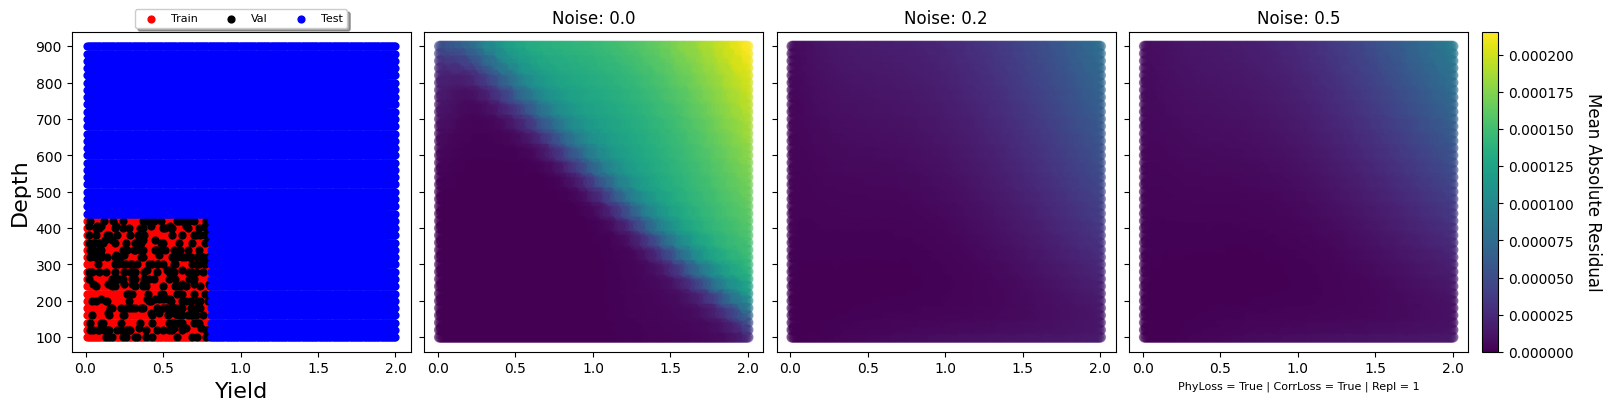

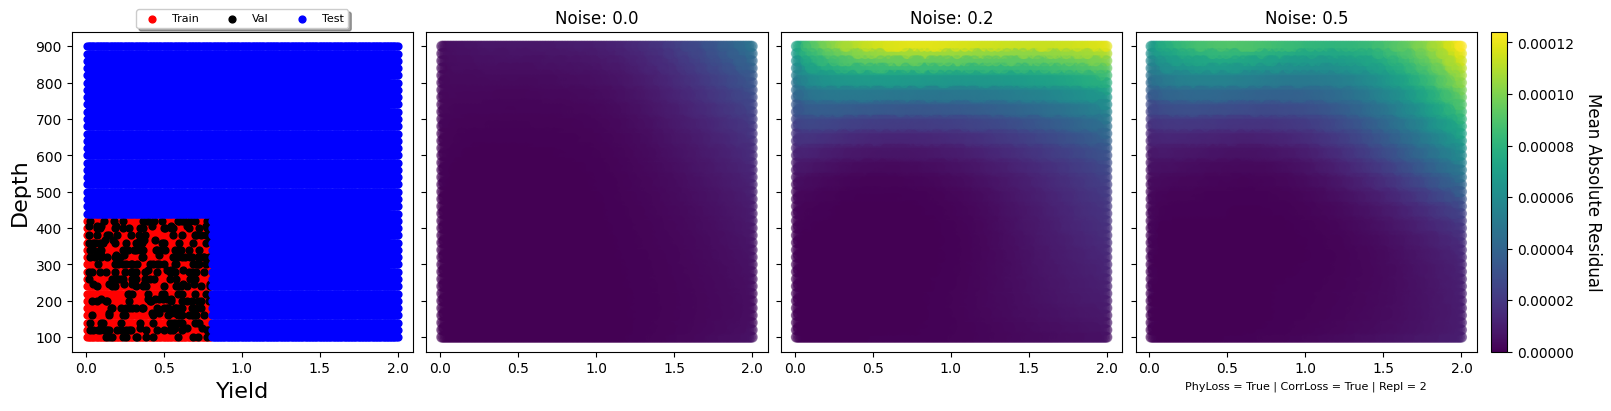

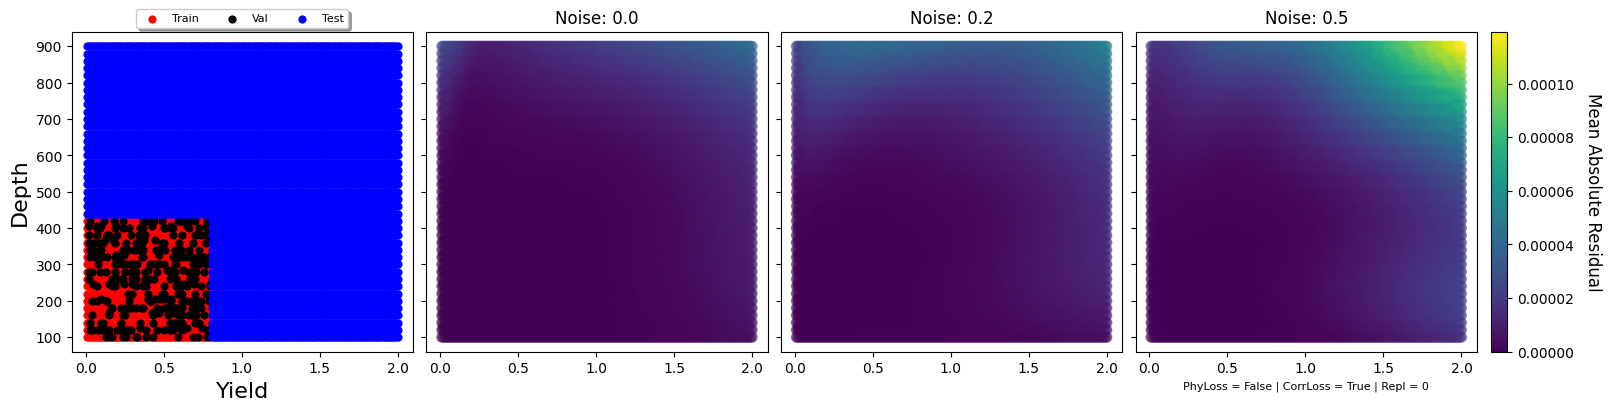

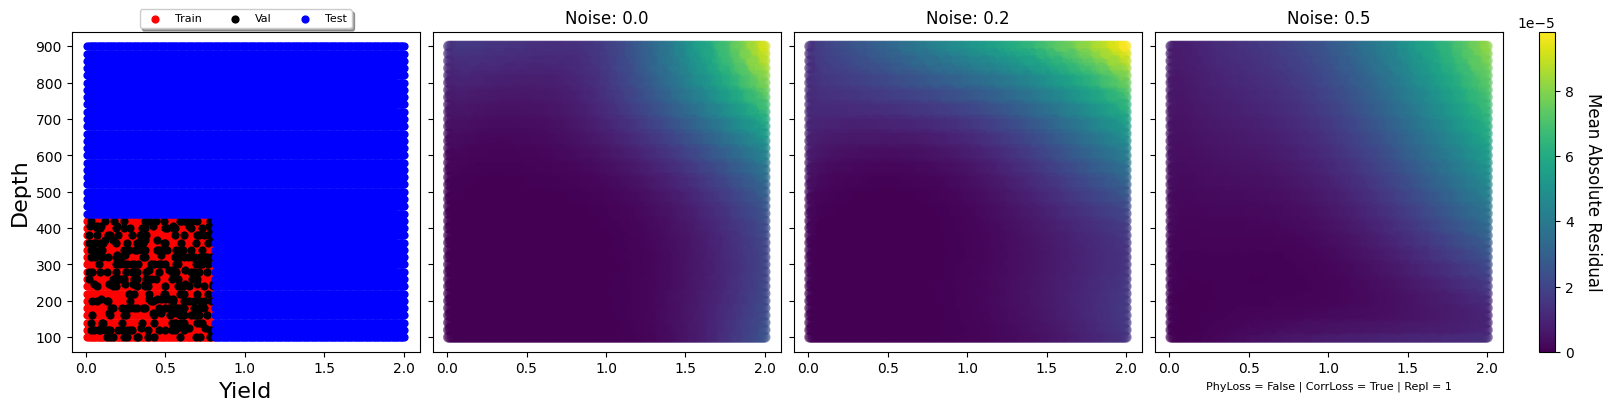

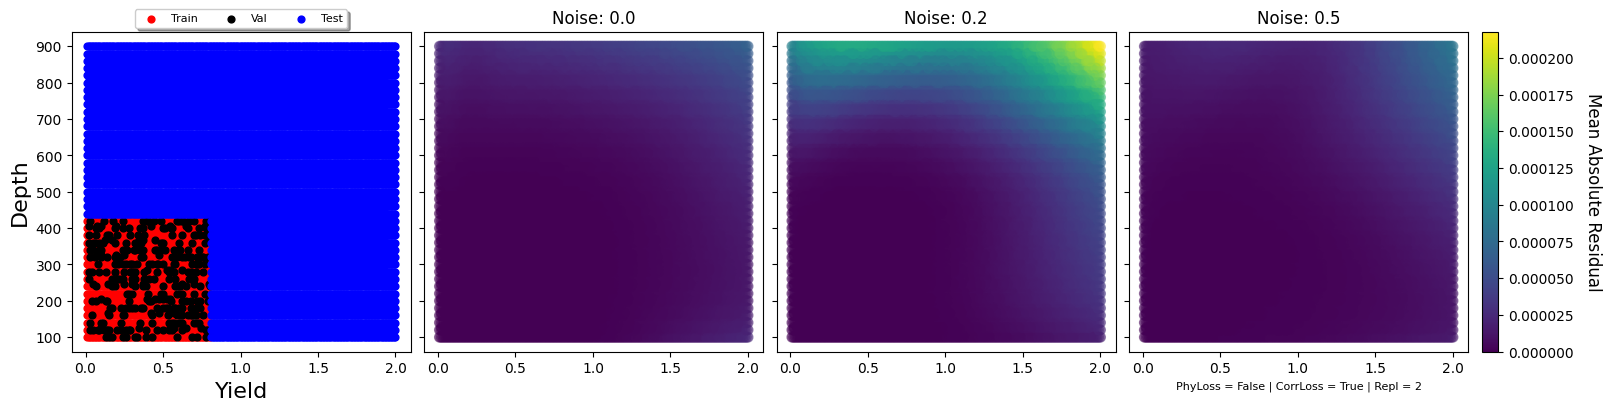

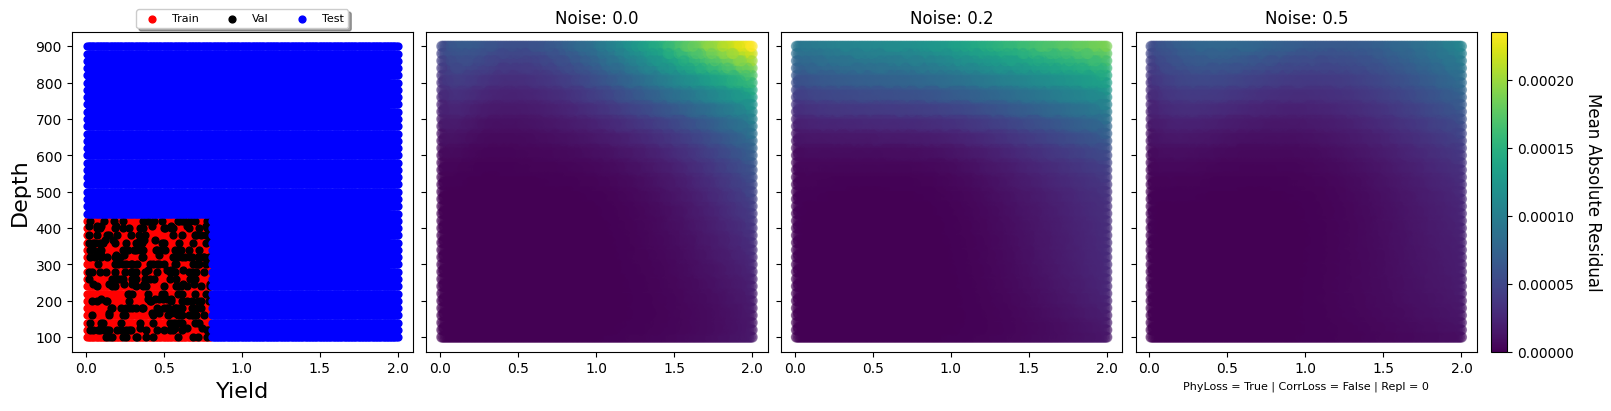

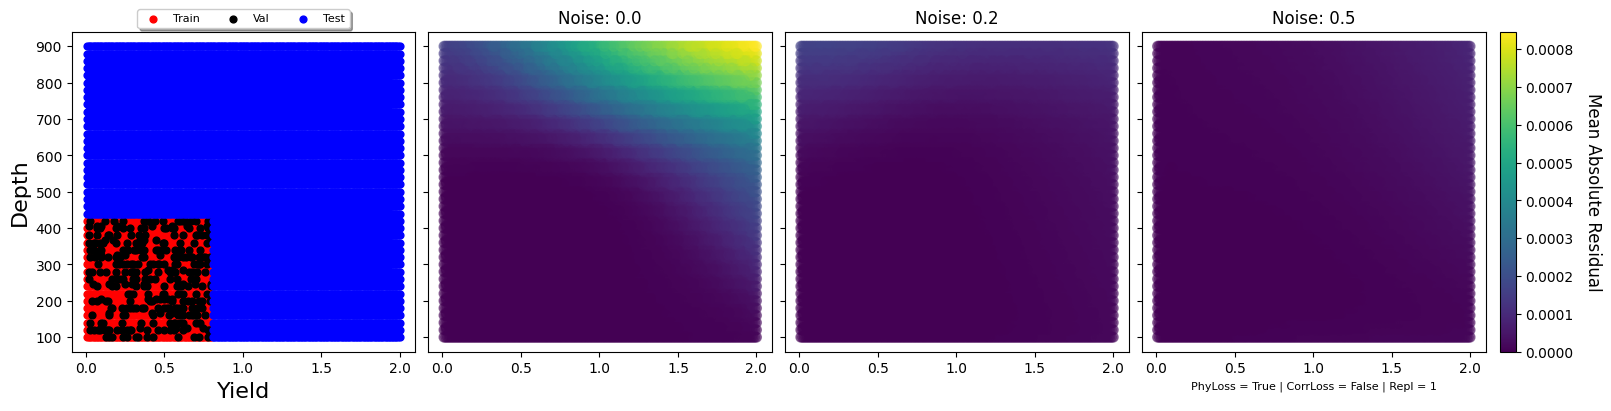

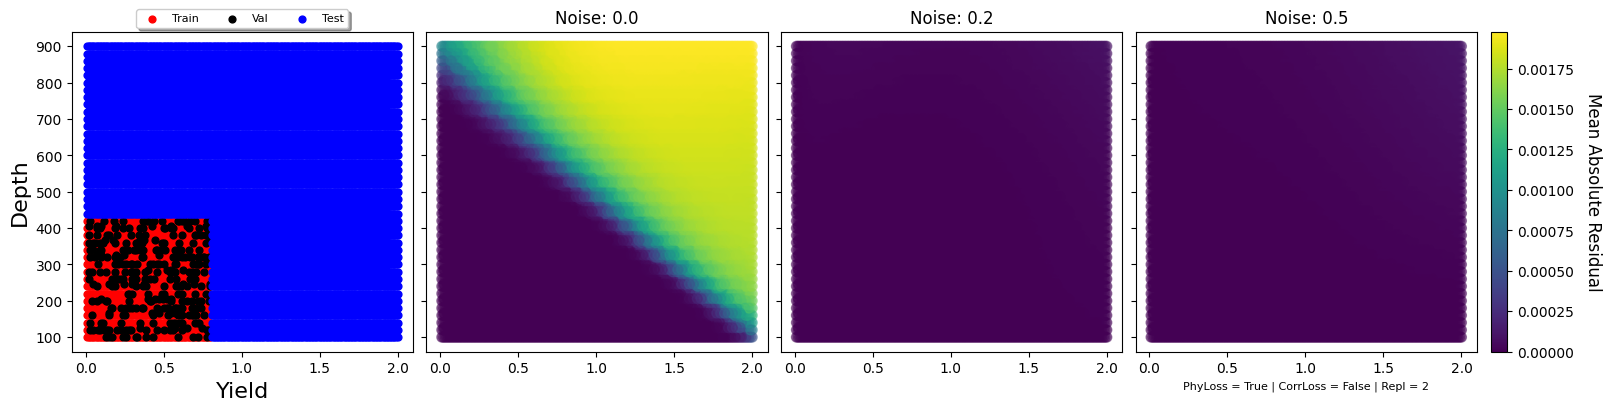

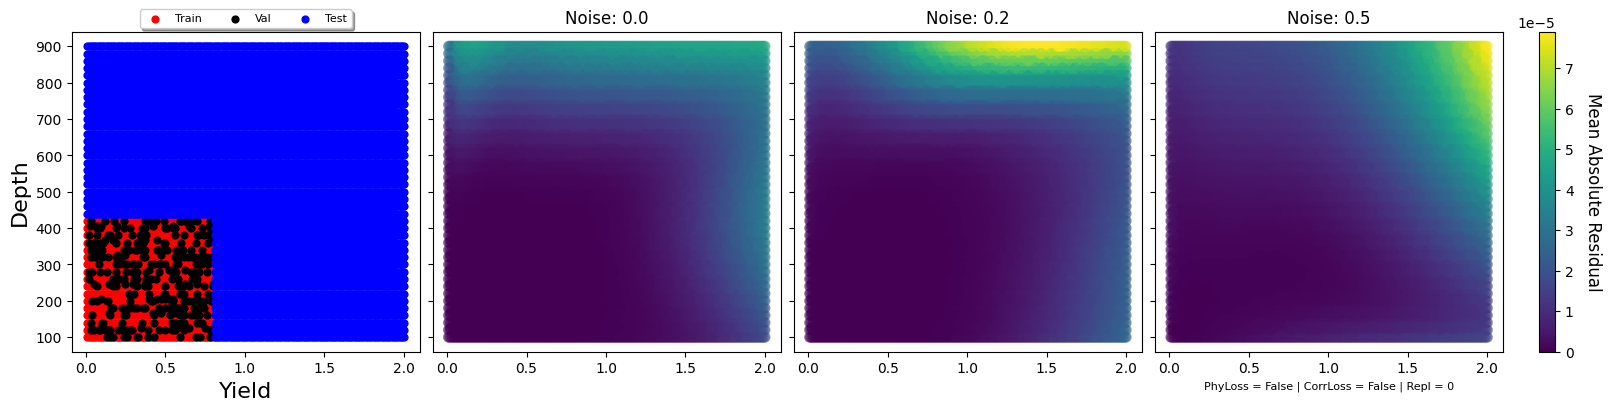

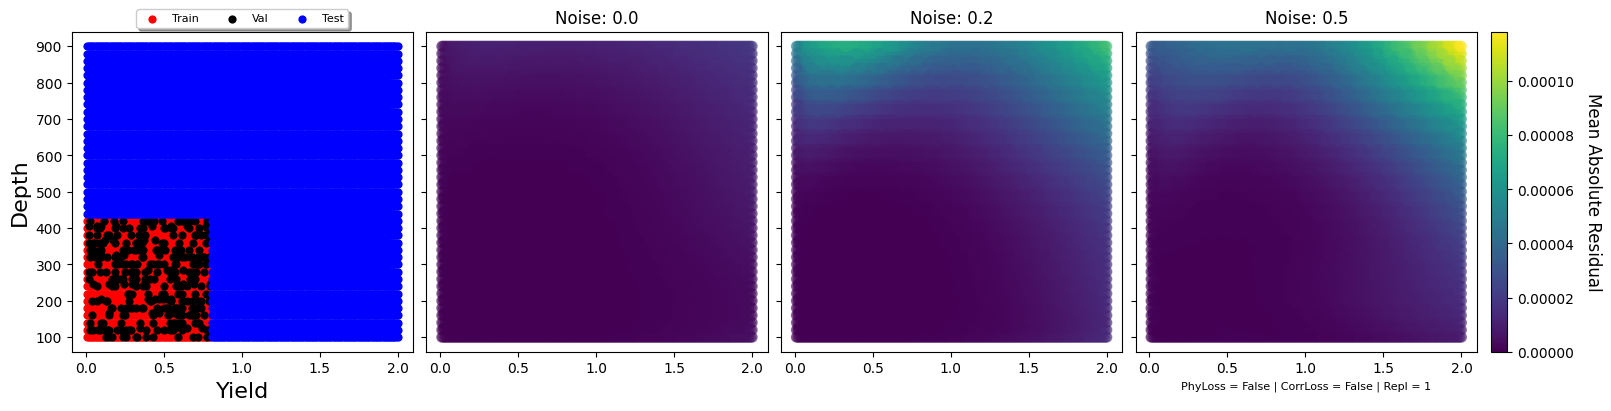

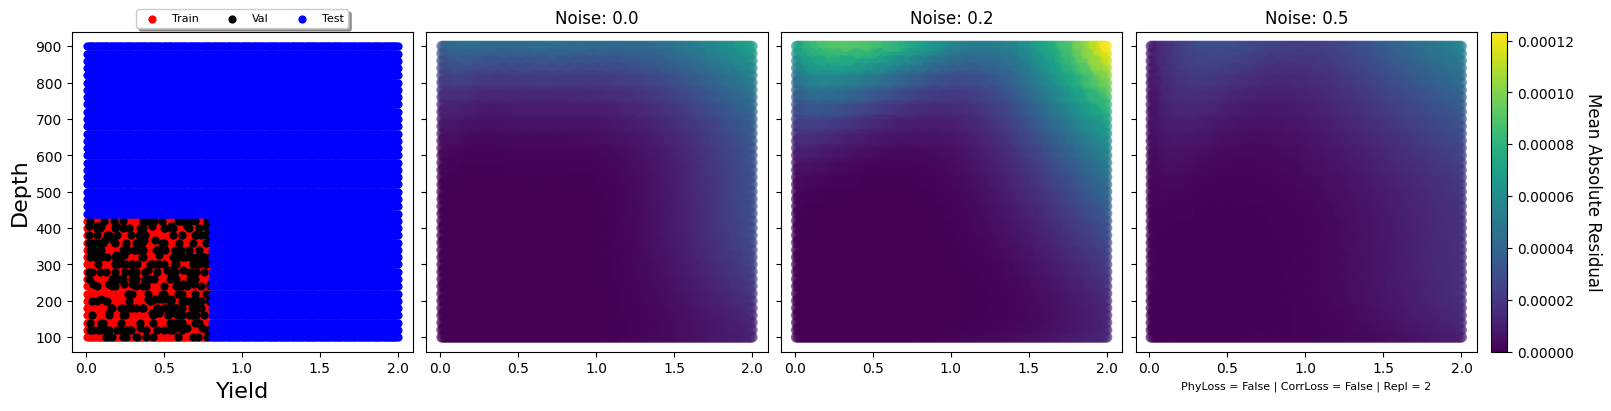

In [64]:
import os 
root = os.path.abspath('')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.io as sio

from matplotlib.colors import Colormap
from matplotlib import cm




# noise_study_ood_phy_domain_sampled, norm = plt.Normalize(0.00010848209, 0.002615124)
# noise_study_ood_domain_no_phy, norm = plt.Normalize(0.0001390961, 0.0025011438) 
# superset, norm = plt.Normalize(0.00010848209, 0.002615124) 


studies = ['noise_study_ood_domain_quad_corr']
sigmas = [0. , .2, .5]
corrs = [True, False]
physs = [True, False]
repls = [0,1,2]

for study in studies:
    for corr in corrs:
        for phys in physs:
            for repl in repls:
                i = 1
                nmax = -np.inf
                nmin = np.inf
                fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4), layout='compressed')
                axs = axs.ravel()
                ax = axs[0]
                s = 24
                ax.scatter(df_train.YIELD, df_train.DEPTH, label='Train', color='red', alpha=1, s=s)
                ax.scatter(df_val.YIELD, df_val.DEPTH, label='Val', color='black', alpha=1, s=s)
                ax.scatter(df_test.YIELD, df_test.DEPTH, label='Test', color='blue', alpha=1, s=s)
                ax.set_ylabel('Depth', fontsize=16)
                ax.set_xlabel('Yield', fontsize=16)
                ax.legend(ncol=3, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, borderaxespad=0)
                # ax.set_title(f'Splits')


                nmin, nmax = 0.,0.
                norm = plt.Normalize(0., 0.005) 
                cmap = cm.get_cmap('viridis')
                im = cm.ScalarMappable(norm=norm, cmap=cmap)
                
                for sigma in sigmas:
                    ax = axs[i]
                            
                    d = f'{root}/results/{study}/{sigma}_{int(phys)}_{int(corr)}_{repl}'
                    print(d)
                    mat = sio.loadmat(f'{d}/SeismicWave_TDSF_forward_PGNN_v1_result.mat')
                    Ymax, Ymin, Xmax, Xmin = mat['Ymax'], mat['Ymin'], mat['Xmax'], mat['Xmin']
                    
                    Yhat_test, Ytest, Xtest  = mat['Yhat_test'], mat['Ytest'], mat['Xtest']
                    Yhat_train, Ytrain, Xtrain = mat['Yhat_train'], mat['Ytrain'], mat['Xtrain']
                    Yhat_val, Yval, Xval = mat['Yhat_val'], mat['Yval'], mat['Xval']
                    
                    print(Yhat_test.shape, Ytest.shape, Xtest.shape)
                    print(Yhat_train.shape, Ytrain.shape, Xtrain.shape)
                    print(Yhat_val.shape, Yval.shape, Xval.shape)
                    
                    Ymax, Ymin, Xmax, Xmin = Ymax[0,0], Ymin[0,0], Xmax[0,0], Xmin[0,0]
                    
                    n_t = 100
                    Xplot = np.vstack([Xtrain, Xval, Xtest])
                    Yplot = np.vstack([Ytrain, Yval, Ytest])
                    Yhat_plot = np.vstack([Yhat_train, Yhat_val, Yhat_test])
                    n = int(Xplot.shape[0]//n_t)
                    w = np.unique(Xplot[:,0].reshape(n, n_t), axis=1)
                    h = np.unique(Xplot[:,1].reshape(n, n_t), axis=1)
                    residuals = (((Yhat_plot.reshape(n, n_t) - Yplot.reshape(n, n_t))**2)).mean(axis=1)
                    
                    if residuals.max() > nmax:
                        nmax = residuals.max()
                    if residuals.min() < nmin:
                        nmin = residuals.min()
                        
                    ax.scatter(w, h, c=residuals, cmap=cmap, s = 50, alpha=0.5)
                    # ax.set_cmap(norm)
                    ax.set_title(f'Noise: {sigma}')

                    i+=1
                ax.set_xlabel(f'PhyLoss = {phys} | CorrLoss = {corr} | Repl = {repl}', fontsize=8)
                norm = plt.Normalize(nmin, nmax) 
                im = cm.ScalarMappable(norm=norm, cmap=cmap)
                for j,ax in enumerate(fig.axes):
                    if j==0:
                        continue
                    sc = ax.get_children()[0]
                    sc.set_norm(norm)
                    sc.set_cmap(cmap)
                cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01)
                # fig.tight_layout()
                cbar.set_label('Mean Absolute Residual', fontsize=12, rotation=270, labelpad=20)
                plt.savefig(f'{d}/disp_resid_v_yield_depth.png')
                # plt.show()
                    


/tmp/ipykernel_437834/3385596618.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


/home/mitch/PythonProjects/tdsf/results/noise_study_ood_domain_quad_corr/0.0_1_1_0
(797000, 1) (797000, 1) (797000, 3)
(129200, 1) (129200, 1) (129200, 3)
(32400, 1) (32400, 1) (32400, 3)
/home/mitch/PythonProjects/tdsf/results/noise_study_ood_domain_quad_corr/0.2_1_1_0
(797000, 1) (797000, 1) (797000, 3)
(129200, 1) (129200, 1) (129200, 3)
(32400, 1) (32400, 1) (32400, 3)
/home/mitch/PythonProjects/tdsf/results/noise_study_ood_domain_quad_corr/0.5_1_1_0
(797000, 1) (797000, 1) (797000, 3)
(129200, 1) (129200, 1) (129200, 3)
(32400, 1) (32400, 1) (32400, 3)
/home/mitch/PythonProjects/tdsf/results/noise_study_ood_domain_quad_corr/0.0_1_1_1
(797000, 1) (797000, 1) (797000, 3)
(129200, 1) (129200, 1) (129200, 3)
(32400, 1) (32400, 1) (32400, 3)
/home/mitch/PythonProjects/tdsf/results/noise_study_ood_domain_quad_corr/0.2_1_1_1
(797000, 1) (797000, 1) (797000, 3)
(129200, 1) (129200, 1) (129200, 3)
(32400, 1) (32400, 1) (32400, 3)
/home/mitch/PythonProjects/tdsf/results/noise_study_ood_doma

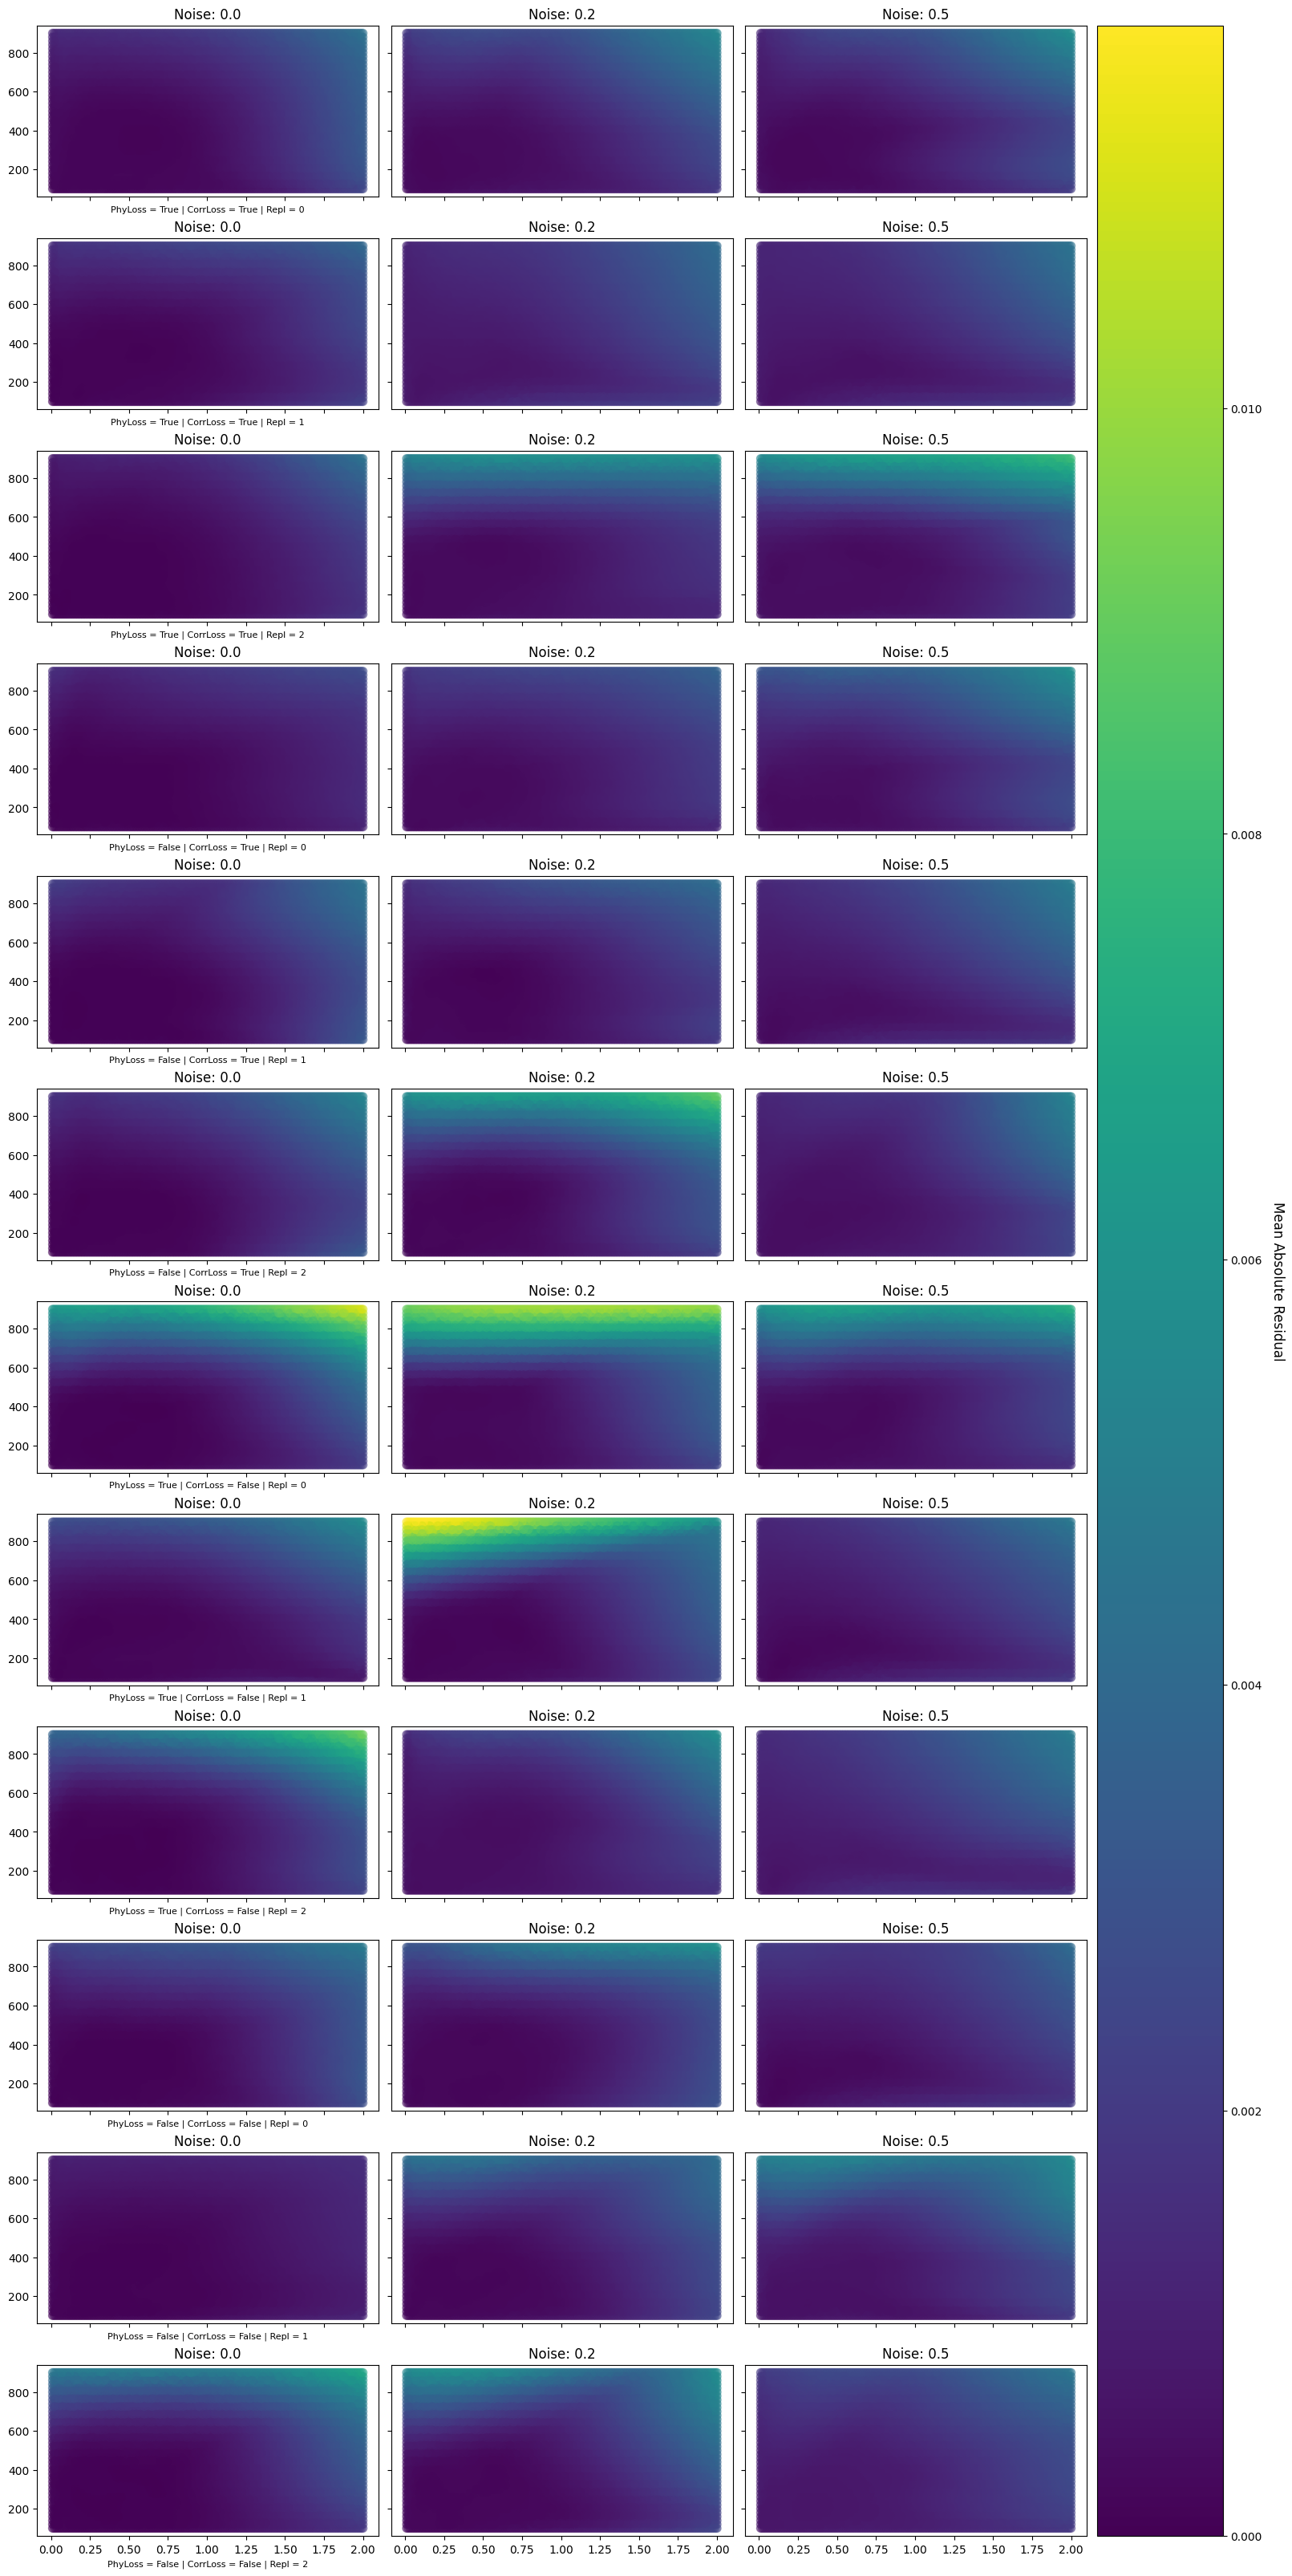

In [7]:
import os 
root = os.path.abspath('')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.io as sio

import matplotlib
from matplotlib.colors import Colormap
from matplotlib import cm




# noise_study_ood_phy_domain_sampled, norm = plt.Normalize(0.00010848209, 0.002615124)
# noise_study_ood_domain_no_phy, norm = plt.Normalize(0.0001390961, 0.0025011438) 
# superset, norm = plt.Normalize(0.00010848209, 0.002615124) 


studies = ['noise_study_ood_domain_quad_corr']
sigmas = [0. , .2, .5]
corrs = [True, False]
physs = [True, False]
repls = [0,1,2]


i = 0
nmax = -np.inf
nmin = np.inf
fig, axs = plt.subplots(nrows=12, ncols=3, sharex=True, sharey=True, figsize=(16,32), layout='compressed')
axs = axs.ravel()
s = 24
# ax.set_title(f'Splits')


nmin, nmax = 0.,0.
norm = plt.Normalize(0., 0.005) 
cmap = cm.get_cmap('viridis')
im = cm.ScalarMappable(norm=norm, cmap=cmap)


for study in studies:
    for corr in corrs:
        for phys in physs:
            for repl in repls:
                for sigma in sigmas:
                    ax = axs[i]
                            
                    d = f'{root}/results/{study}/{sigma}_{int(phys)}_{int(corr)}_{repl}'
                    print(d)
                    mat = sio.loadmat(f'{d}/SeismicWave_TDSF_forward_PGNN_v1_result.mat')
                    Ymax, Ymin, Xmax, Xmin = mat['Ymax'], mat['Ymin'], mat['Xmax'], mat['Xmin']
                    
                    Yhat_test, Ytest, Xtest  = mat['Yhat_test'], mat['Ytest'], mat['Xtest']
                    Yhat_train, Ytrain, Xtrain = mat['Yhat_train'], mat['Ytrain'], mat['Xtrain']
                    Yhat_val, Yval, Xval = mat['Yhat_val'], mat['Yval'], mat['Xval']
                    
                    print(Yhat_test.shape, Ytest.shape, Xtest.shape)
                    print(Yhat_train.shape, Ytrain.shape, Xtrain.shape)
                    print(Yhat_val.shape, Yval.shape, Xval.shape)
                    
                    Ymax, Ymin, Xmax, Xmin = Ymax[0,0], Ymin[0,0], Xmax[0,0], Xmin[0,0]
                    
                    n_t = 100
                    Xplot = np.vstack([Xtrain, Xval, Xtest])
                    Yplot = np.vstack([Ytrain, Yval, Ytest])
                    Yhat_plot = np.vstack([Yhat_train, Yhat_val, Yhat_test])
                    n = int(Xplot.shape[0]//n_t)
                    w = np.unique(Xplot[:,0].reshape(n, n_t), axis=1)
                    h = np.unique(Xplot[:,1].reshape(n, n_t), axis=1)
                    residuals = ((abs(Yhat_plot.reshape(n, n_t) - Yplot.reshape(n, n_t)))).mean(axis=1)
                    
                    if residuals.max() > nmax:
                        nmax = residuals.max()
                    if residuals.min() < nmin:
                        nmin = residuals.min()
                        
                    ax.scatter(w, h, c=residuals, cmap=cmap, s = 50, alpha=0.5)
                    # ax.set_cmap(norm)
                    ax.set_title(f'Noise: {sigma}')
                    
                    if i%3 == 0:
                        ax.set_xlabel(f'PhyLoss = {phys} | CorrLoss = {corr} | Repl = {repl}', fontsize=8)
                    
                    i+=1
                    
    norm = plt.Normalize(nmin, nmax) 
    im = cm.ScalarMappable(norm=norm, cmap=cmap)
    for j,ax in enumerate(fig.axes):
        if type(ax.get_children()[0]) == matplotlib.spines.Spine:
            continue
        sc = ax.get_children()[0]
        sc.set_norm(norm)
        sc.set_cmap(cmap)
    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01)
    # fig.tight_layout()
    cbar.set_label('Mean Absolute Residual', fontsize=12, rotation=270, labelpad=20)
    # plt.savefig(f'{d}/disp_resid_v_yield_depth.png')
    # plt.show()
        


In [83]:
import matplotlib 
type(ax.get_children()[0]) == matplotlib.spines.Spine

True

In [77]:
1 % 3

1

In [72]:
sc

In [69]:
nmin, nmax

(0.0, 0.04394845)

In [ ]:
import os 
root = os.path.abspath('')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.io as sio

from matplotlib.colors import Colormap
from matplotlib import cm




# noise_study_ood_phy_domain_sampled, norm = plt.Normalize(0.00010848209, 0.002615124)
# noise_study_ood_domain_no_phy, norm = plt.Normalize(0.0001390961, 0.0025011438) 
# superset, norm = plt.Normalize(0.00010848209, 0.002615124) 
norm = plt.Normalize(0.00010848209, 0.0033385672) 
cmap = cm.get_cmap('viridis')
im = cm.ScalarMappable(norm=norm, cmap=cmap)

# studies = ['noise_study_ood_domain_no_phy_smaller','noise_study_ood_domain_phy_smaller' ]
studies = ['noise_study_ood_domain_no_phy_smaller','noise_study_ood_domain_phy_smaller', 'noise_study_ood_domain_no_phy','noise_study_ood_phy_domain_sampled']
sigmas = [0.00, 0.2, 0.5]
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(16,4), layout='compressed')
axs = axs.ravel()
ax = axs[0]
s = 24
ax.scatter(df_train.YIELD, df_train.DEPTH, label='Train', color='red', alpha=1, s=s)
ax.scatter(df_val.YIELD, df_val.DEPTH, label='Val', color='black', alpha=1, s=s)
ax.scatter(df_test.YIELD, df_test.DEPTH, label='Test', color='blue', alpha=1, s=s)
ax.set_ylabel('Depth', fontsize=16)
ax.set_xlabel('Yield', fontsize=16)
ax.legend(ncol=3, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 1.07), fancybox=True, shadow=True, borderaxespad=0)
# ax.set_title(f'Splits')
i = 1
for study in studies:
    for sigma in sigmas:
                
        d = f'{root}/results/{study}/{sigma}'
        # print(d)
        mat = sio.loadmat(f'{d}/SeismicWave_TDSF_forward_PGNN_v1_result.mat')
        Ymax, Ymin, Xmax, Xmin = mat['Ymax'], mat['Ymin'], mat['Xmax'], mat['Xmin']
        Ymax, Ymin, Xmax, Xmin = Ymax[0,0], Ymin[0,0], Xmax[0,0], Xmin[0,0]

        Yhat_test, Ytest, Xtest  = mat['Yhat_test'], mat['Ytest'], mat['Xtest']
        Yhat_train, Ytrain, Xtrain = mat['Yhat_train'], mat['Ytrain'], mat['Xtrain']
        Yhat_val, Yval, Xval = mat['Yhat_val'], mat['Yval'], mat['Xval']
        
        
        
        
        resid_test = abs(Yhat_test - Ytest)
        resid_train = abs(Yhat_train - Ytrain)
        resid_val = abs(Yhat_val - Yval)
        print(f'{study}, {sigma}, {resid_train.mean()}, {resid_val.mean()}, {resid_test.mean()}')

        



# Plot Examples

In [ ]:
import os 
root = os.path.abspath('')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.io as sio

from matplotlib.colors import Colormap
from matplotlib import cm




# noise_study_ood_phy_domain_sampled, norm = plt.Normalize(0.00010848209, 0.002615124)
# noise_study_ood_domain_no_phy, norm = plt.Normalize(0.0001390961, 0.0025011438) 
# superset, norm = plt.Normalize(0.00010848209, 0.002615124) 
norm = plt.Normalize(0.00010848209, 0.0033385672) 
cmap = cm.get_cmap('viridis')
im = cm.ScalarMappable(norm=norm, cmap=cmap)

# studies = ['noise_study_ood_domain_no_phy_smaller','noise_study_ood_domain_phy_smaller' ]
studies = ['noise_study_ood_domain_no_phy','noise_study_ood_phy_domain_sampled']
sigmas = [0.00]
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12 ,4), layout='compressed')
axs = axs.ravel()

# ax.set_title(f'Splits')
for study in studies:
    for sigma in sigmas:
                
        d = f'{root}/results/{study}/{sigma}'
        # print(d)
        mat = sio.loadmat(f'{d}/SeismicWave_TDSF_forward_PGNN_v1_result.mat')
        Ymax, Ymin, Xmax, Xmin = mat['Ymax'], mat['Ymin'], mat['Xmax'], mat['Xmin']
        Ymax, Ymin, Xmax, Xmin = Ymax[0,0], Ymin[0,0], Xmax[0,0], Xmin[0,0]

        Yhat_test, Ytest, Xtest  = mat['Yhat_test'], mat['Ytest'], mat['Xtest']
        Yhat_train, Ytrain, Xtrain = mat['Yhat_train'], mat['Ytrain'], mat['Xtrain']
        Yhat_val, Yval, Xval = mat['Yhat_val'], mat['Yval'], mat['Xval']
        
        n_t = 100
        Xplot = np.vstack([Xtrain, Xval, Xtest])
        n = int(Xplot.shape[0]//n_t)
        w = np.unique(Xplot[:,0].reshape(n, n_t), axis=1)
        h = np.unique(Xplot[:,1].reshape(n, n_t), axis=1)

        Yplot = np.vstack([Ytrain, Yval, Ytest]).reshape(n, n_t)
        Yhat_plot = np.vstack([Yhat_train, Yhat_val, Yhat_test]).reshape(n, n_t)
        
        ex1 = np.where((w==2.0) & (h==100.))[0]
        ex1_true = Yplot[ex1][0,:]
        ex1_pred = Yhat_plot[ex1][0,:]

        ex2 = np.where((w==1.0) & (h==400.))[0]
        ex2_true = Yplot[ex2][0,:]
        ex2_pred = Yhat_plot[ex2][0,:]

        if 'no_phy' in study: 
            ax = axs[0]
            ax.set_title('Physics Loss Removed')
        else: 
            ax = axs[1]
            ax.set_title('Physics Loss Included')
            

        ax.plot(ex1_true, c='black', linestyle='-', label='True')
        ax.plot(ex1_pred, c='black', linestyle='--', label='Predicted')

        ax.plot(ex2_true, c='red', linestyle='-', label='True')
        ax.plot(ex2_pred, c='red', linestyle='--', label='Predicted')
        # ax.set_title(f'Noise: {sigma}')
        
    axs[1].legend(['w=2.0, h=100', 'Predicted', 'w=1.0, h=400', 'Predicted'])



In [ ]:
import os 
root = os.path.abspath('')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.io as sio

from matplotlib.colors import Colormap
from matplotlib import cm




# noise_study_ood_phy_domain_sampled, norm = plt.Normalize(0.00010848209, 0.002615124)
# noise_study_ood_domain_no_phy, norm = plt.Normalize(0.0001390961, 0.0025011438) 
# superset, norm = plt.Normalize(0.00010848209, 0.002615124) 
norm = plt.Normalize(0.00010848209, 0.0033385672) 
cmap = cm.get_cmap('viridis')
im = cm.ScalarMappable(norm=norm, cmap=cmap)

# studies = ['noise_study_ood_domain_no_phy_smaller','noise_study_ood_domain_phy_smaller' ]
studies = ['noise_study_ood_domain_no_phy_smaller','noise_study_ood_domain_phy_smaller']
sigmas = [0.00]
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,4), layout='compressed')
axs = axs.ravel()

# ax.set_title(f'Splits')
for study in studies:
    for sigma in sigmas:
                
        d = f'{root}/results/{study}/{sigma}'
        # print(d)
        mat = sio.loadmat(f'{d}/SeismicWave_TDSF_forward_PGNN_v1_result.mat')
        Ymax, Ymin, Xmax, Xmin = mat['Ymax'], mat['Ymin'], mat['Xmax'], mat['Xmin']
        Ymax, Ymin, Xmax, Xmin = Ymax[0,0], Ymin[0,0], Xmax[0,0], Xmin[0,0]

        Yhat_test, Ytest, Xtest  = mat['Yhat_test'], mat['Ytest'], mat['Xtest']
        Yhat_train, Ytrain, Xtrain = mat['Yhat_train'], mat['Ytrain'], mat['Xtrain']
        Yhat_val, Yval, Xval = mat['Yhat_val'], mat['Yval'], mat['Xval']
        
        n_t = 100
        Xplot = np.vstack([Xtrain, Xval, Xtest])
        n = int(Xplot.shape[0]//n_t)
        w = np.unique(Xplot[:,0].reshape(n, n_t), axis=1)
        h = np.unique(Xplot[:,1].reshape(n, n_t), axis=1)

        Yplot = np.vstack([Ytrain, Yval, Ytest]).reshape(n, n_t)
        Yhat_plot = np.vstack([Yhat_train, Yhat_val, Yhat_test]).reshape(n, n_t)
        
        ex1 = np.where((w==2.0) & (h==100.))[0]
        ex1_true = Yplot[ex1][0,:]
        ex1_pred = Yhat_plot[ex1][0,:]

        ex2 = np.where((w==1.0) & (h==400.))[0]
        ex2_true = Yplot[ex2][0,:]
        ex2_pred = Yhat_plot[ex2][0,:]

        if 'no_phy' in study: 
            ax = axs[0]
            ax.set_title('Physics Loss Removed')
        else: 
            ax = axs[1]
            ax.set_title('Physics Loss Included')
            plt.legend(['w=2.0, h=100', 'Predicted', 'w=1.0, h=400', 'Predicted'])

        ax.plot(ex1_true, c='black', linestyle='-', label='True')
        ax.plot(ex1_pred, c='black', linestyle='--', label='Predicted')

        ax.plot(ex2_true, c='red', linestyle='-', label='True')
        ax.plot(ex2_pred, c='red', linestyle='--', label='Predicted')
        # ax.set_title(f'Noise: {sigma}')
        
    axs[1].legend(['w=2.0, h=100', 'Predicted', 'w=1.0, h=400', 'Predicted'])



In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16,4), layout='compressed')
axs = axs.ravel()

ex1 = np.where((w==2.0) & (h==100.))[0]
ex1_true = Yplot[ex1][0,:]
ex1_pred = Yhat_plot[ex1][0,:]

ex2 = np.where((w==1.0) & (h==400.))[0]
ex2_true = Yplot[ex2][0,:]
ex2_pred = Yhat_plot[ex2][0,:]

if 'no_phy' in study: ax = axs[0]
else: ax = axs[1]

ax.plot(ex1_true, c='black', linestyle='-', label='True')
ax.plot(ex1_pred, c='black', linestyle='--', label='Predicted')

ax.plot(ex2_true, c='red', linestyle='-', label='True')
ax.plot(ex2_pred, c='red', linestyle='--', label='Predicted')



In [ ]:
np.where((w==1.0) & (h==400.))

In [ ]:
import os 
root = os.path.abspath('')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.io as sio

# 'noise_study_ood'
# noise_study_ood_phy_domain_sampled
studies = ['noise_study_ood_phy_domain_sampled']
sigmas = [0.00, 0.2, 0.5] # 0.01, 0.1, 0.2,

for study in studies:
    for sigma in sigmas:
        d = f'{root}/results/{study}/{sigma}'
        print(d)
        mat = sio.loadmat(f'{d}/SeismicWave_TDSF_forward_PGNN_v1_result.mat')
        Ymax, Ymin, Xmax, Xmin = mat['Ymax'], mat['Ymin'], mat['Xmax'], mat['Xmin']
        
        Yhat_test, Ytest, Xtest  = mat['Yhat_test'], mat['Ytest'], mat['Xtest']
        Yhat_train, Ytrain, Xtrain = mat['Yhat_train'], mat['Ytrain'], mat['Xtrain']
        Yhat_val, Yval, Xval = mat['Yhat_val'], mat['Yval'], mat['Xval']
        
        Ymax, Ymin, Xmax, Xmin = Ymax[0,0], Ymin[0,0], Xmax[0,0], Xmin[0,0]

        n_t = 100
        n_test = int(Ytest.shape[0]//n_t)
        t = Xtest[:,-1].reshape(n_test, n_t)
        residuals = Ytest.reshape(n_test, n_t) - Yhat.reshape(n_test, n_t)

        ax = sns.lineplot(x=t.reshape(-1,1)[:,0], y=residuals.reshape(-1,1)[:,0], alpha=0.5, errorbar='sd', label=f'{sigma}')

plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.savefig(f'{root}/results/{study}/disp_resid_v_time_errbar.png')
plt.show()

        
        



# Recompute predictions

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 29 15:39:51 2023

This script trains PINN model for TDSF supplied by AFTAC-CRADA
Inputs: yield (w), depth (h), time (t)
Output: displacement (S)

@author: shhong
"""

#%% Load Moduels

import os
root = os.path.abspath('')
# root = '/home/ubuntu/tdsf'

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import scipy.io as sio
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# from sklearn.metrics import confusion_matrix
# from sklearn.preprocessing import OneHotEncoder

# device = torch.device('cuda:0')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

study = 'noise_study_ood_phy_domain_sampled'

#%% Load Data

# path = 'E:\Hong\Research Projects\PINN\Data'
path = f'{root}/data'

filename = 'tdsf_002_train.pickle'
df_train_all = pd.read_pickle(path + '/' + filename)

filename = 'tdsf_002_val.pickle'
df_test_all = pd.read_pickle(path + '/' + filename)

df_data_all = pd.concat([df_train_all, df_test_all], axis=0)


#%% Select Material

# [Tuff-Rhyolite, Granite, Shale, Salt, Wet-Granite, Wet-Tuff]

name_prefix = '_FAR.'
name_material = 'Tuff-Rhyolite'

df_data = df_data_all[df_data_all['material'] == name_prefix + name_material]
df_data = df_data.reset_index(drop=True)

# round YIELD and DEPTH to 2 decimal places
df_data.YIELD = df_data.YIELD.round(2)
df_data.DEPTH = df_data.DEPTH.round(2)

# splits df into train and test by yield and depth quantiles
qnts = [.1, .9]
ylds, dpths = df_data.YIELD.quantile(qnts, interpolation='nearest'), df_data.DEPTH.quantile(qnts, interpolation='nearest')
train_qnt = (df_data.YIELD >= ylds.min()) & (df_data.YIELD <= ylds.max()) & (df_data.DEPTH >= dpths.min()) & (df_data.DEPTH <= dpths.max())

# split data into train and test by domain (inner and outer)
df_train = df_data[train_qnt].reset_index(drop=True)
df_test = df_data[~train_qnt].reset_index(drop=True)

# split train into train and validation, randomly selected from the inner domain
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=0)
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)


# plot train and test yields and depths
s = 30
plt.figure()
plt.scatter(df_train.YIELD, df_train.DEPTH, label='Training Set', color='red', alpha=0.2, s=s)
plt.scatter(df_val.YIELD, df_val.DEPTH, label='Validation Set', color='black', alpha=0.2, s=s)
plt.scatter(df_test.YIELD, df_test.DEPTH, label='Test Set', color='blue', alpha=0.2, s=s)
plt.xlabel('Yield')
plt.ylabel('Depth')
plt.legend()
plt.title('Data Domains')
plt.savefig(f'{root}/results/{study}/domains.png')
# plt.close('all')
plt.show()


In [ ]:

#%% Data Arrangement

trunc = 1000
ds = 10
dt = 0.001

tv = np.arange(1,trunc+1)*dt
tv = tv[::ds]

# Define Train Set
tdsf = df_train.DATA
wvec = df_train.YIELD
hvec = df_train.DEPTH
t_tdsf = tdsf[0][:trunc]
Xtrain = np.concatenate((wvec[0]*np.ones((tv.size,1)), hvec[0]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)
Ytrain = np.reshape(t_tdsf[::ds], (-1,1))
for ndx in range(1, df_train.shape[0]):
    t_tdsf = tdsf[ndx][:trunc]
    Xtemp = np.concatenate((wvec[ndx]*np.ones((tv.size,1)), hvec[ndx]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)        
    Xtrain = np.concatenate((Xtrain, Xtemp), axis=0)
    Ytrain = np.concatenate((Ytrain, np.reshape(t_tdsf[::ds], (-1,1))), axis=0)
Xtrain = Xtrain.astype(np.float32)
Ytrain = Ytrain.astype(np.float32)

# Define Val Set
tdsf = df_val.DATA
wvec = df_val.YIELD
hvec = df_val.DEPTH
t_tdsf = tdsf[0][:trunc]
Xval = np.concatenate((wvec[0]*np.ones((tv.size,1)), hvec[0]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)
Yval = np.reshape(t_tdsf[::ds], (-1,1))
for ndx in range(1, df_val.shape[0]):
    t_tdsf = tdsf[ndx][:trunc]
    Xtemp = np.concatenate((wvec[ndx]*np.ones((tv.size,1)), hvec[ndx]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)        
    Xval = np.concatenate((Xval, Xtemp), axis=0)
    Yval = np.concatenate((Yval, np.reshape(t_tdsf[::ds], (-1,1))), axis=0)
Xval = Xval.astype(np.float32)
Yval = Yval.astype(np.float32)

# Define Test Set
tdsf = df_test.DATA
wvec = df_test.YIELD
hvec = df_test.DEPTH
t_tdsf = tdsf[0][:trunc]
Xtest = np.concatenate((wvec[0]*np.ones((tv.size,1)), hvec[0]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)
Ytest = np.reshape(t_tdsf[::ds], (-1,1))
for ndx in range(1, df_test.shape[0]):
    t_tdsf = tdsf[ndx][:trunc]
    Xtemp = np.concatenate((wvec[ndx]*np.ones((tv.size,1)), hvec[ndx]*np.ones((tv.size,1)), np.reshape(tv,(-1,1))), axis=1)        
    Xtest = np.concatenate((Xtest, Xtemp), axis=0)
    Ytest = np.concatenate((Ytest, np.reshape(t_tdsf[::ds], (-1,1))), axis=0)
Xtest = Xtest.astype(np.float32)
Ytest = Ytest.astype(np.float32)


#%% Preprocessing

# Min-Max Normalization
Xscaler = MinMaxScaler()
Xscaler.fit(np.vstack([Xtrain, Xval, Xtest]))
MaxX = Xscaler.data_max_
MinX = Xscaler.data_min_

Yscaler = MinMaxScaler()
Yscaler.fit(np.vstack([Ytrain, Yval, Ytest]))
MaxY = Yscaler.data_max_
MinY = Yscaler.data_min_

Ztrain = Yscaler.transform(Ytrain)
Zval = Yscaler.transform(Yval)
Ztest = Yscaler.transform(Ytest)

# Shuffle Data
numdata = Xtrain.shape[0]
Ztrain_base = Ztrain.copy()


In [ ]:
# Fully Connected NN
class FCNN_Net(nn.Module):

    def __init__(self, numIn, numOut):
        super(FCNN_Net, self).__init__()
        self.fc1 = nn.Linear(numIn, 128)
        self.fc2 = nn.Linear(128, 6)
        self.fc3 = nn.Linear(6, numOut)
        
    def forward(self, w, h, t):        
        inputs = torch.cat([w,h,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns        
        # in_size = x.size(0)
        # inputs = x.view(in_size, -1)
        layer1_out = torch.tanh(self.fc1(inputs))
        layer2_out = torch.tanh(self.fc2(layer1_out))
        output = (self.fc3(layer2_out))
        return output

In [ ]:
import os 
root = os.path.abspath('')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.io as sio

# 'noise_study_ood'
# noise_study_ood_phy_domain_sampled
studies = ['noise_study_ood_phy_domain_sampled']
sigmas = [0.00, 0.01, 0.1, 0.2, 0.5] 

for study in studies:
    for sigma in sigmas:
        d = f'{root}/results/{study}/{sigma}'
        print(d)
        mat = sio.loadmat(f'{d}/SeismicWave_TDSF_forward_PGNN_v1_result.mat')

        Yhat_test, Ytest, Xtest, Ymax, Ymin, Xmax, Xmin = mat['Yhat_test'], mat['Ytest'], mat['Xtest'], mat['Ymax'], mat['Ymin'], mat['Xmax'], mat['Xmin']

        model_data = torch.load(f'{d}/SeismicWave_TDSF_forward_PGNN_v1.pth')
        model = model_data['model']
        model.load_state_dict(model_data['state_dict'])

        model.to('cpu')
        model.eval()

        # validation set
        Xin = (Xval-MinX)/(MaxX-MinX)
        Xt = torch.from_numpy(Xin)
        Zhat = model(torch.reshape(Xt[:,0], (-1,1)), torch.reshape(Xt[:,1], (-1,1)), torch.reshape(Xt[:,2], (-1,1)))
        Zhat = Zhat.detach().numpy()
        Yhat_val = Yscaler.inverse_transform(Zhat)


        # train set
        Xin = (Xtrain-MinX)/(MaxX-MinX)
        Xt = torch.from_numpy(Xin)
        Zhat = model(torch.reshape(Xt[:,0], (-1,1)), torch.reshape(Xt[:,1], (-1,1)), torch.reshape(Xt[:,2], (-1,1)))
        Zhat = Zhat.detach().numpy()
        Yhat_train = Yscaler.inverse_transform(Zhat)

        filename = f'{d}/SeismicWave_TDSF_forward_PGNN_v1_result.mat'
        sio.savemat(filename, 
                {
                'Yhat_train':Yhat_train, 'Ytrain':Ytrain, 'Xtrain':Xtrain,
                'Yhat_test':Yhat_test, 'Ytest':Ytest, 'Xtest':Xtest, 
                'Yhat_val':Yhat_val,'Yval':Yval, 'Xval':Xval,
                'Ymax':MaxY, 'Ymin':MinY, 'Xmax':MaxX, 'Xmin':MinX
                })

In [ ]:
f'{root}/results/{study}/disp_resid_v_yield_depth.png'

In [ ]:
np.unique(w, axis=1).shape, np.unique(h, axis=1).shape

In [ ]:
np.unique(w, axis=1)

In [ ]:
import pandas as pd
df = pd.read_csv('results/results.csv')
df = df.melt(id_vars=['Study', 'Train Domain', 'Physics Loss?', 'Noise Level'], var_name='Split', value_name='Loss').reset_index(drop=True)
df

In [ ]:
import seaborn as sns
sns.relplot(df, x='Noise Level', y='Loss', hue='Physics Loss?', col='Split', row='Train Domain', kind='line')

In [ ]:
ax = sns.lineplot(df[df['Train Domain']=='Small'], x='Noise Level', y='MAE - Test', hue='Physics Loss?')
ax

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(16,4), layout='compressed')

for i, df_grouped in df.groupby(['Train Domain', 'Physics Loss?']):
    x = df_grouped['Noise Level'].values
    y = df_grouped['MAE - Test'].values
    label = f''
    ax.plot(x=x, y=y)
